In [1]:
## The goal of this notebook is to reproduce the results of the nonlinear backdoor 
## (from Vahid's paper) notebook (and corresponding python script)

## Module imports
import pandas as pd
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.causalpfn.causal_estimator import CausalEstimator
from functools import reduce

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
## MAIN HYPERPARAMETER
N_DISC_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10]

## Main body
# Discretization function
def discretize_treatment(T: np.ndarray, N: int) -> np.ndarray:
    """Returns discretized version of T. Assumes range of T is [0, 1].

    Args:
        T (np.ndarray): The raw treatment data 
        N (int): The number of discretized treatment values to use

    Returns:
        np.ndarray: The discretized treatment data
    """
    dt = 1 / (N - 1)
    T_discrete = np.round(np.array(T, dtype=np.float32) / dt) * dt

    return T_discrete

# RMSE function
def calculate_rmse(y_pred, y_true):
    result = np.mean(np.power(y_pred - y_true, 2))
    result = np.sqrt(result)

    return result

In [3]:
## Synthetic data generation

# Generate synthetic data, using the DGP from Vahid's paper - nonlinear backdoor
np.random.seed(42)
n, d = 2000, 1
X = np.random.normal(2, 1, size=(n, d)).astype(np.float32)
T = (0.1 * X[:, 0] ** 2 - X[:, 0] + np.random.normal(1, 2, size=n)).astype(np.float32)
T = T - T.min() # Rescale
T = T / T.max() # Rescale
Y = (0.5 * T ** 2 - T * X[:, 0] + np.random.normal(0, 2, size=n)).astype(np.float32)
def drf(t): return 0.5 * t ** 2 - 2 * t # true dose-response funcion

df = pd.concat([
    pd.DataFrame(data=X, columns=["x"]), 
    pd.DataFrame(data=T, columns=["T"]), 
    pd.DataFrame(data=Y, columns=["Y"])
    ], axis=1)

In [4]:
## Main prediction loop. Takes about 6 minutes to run.
list_of_epos = [] # [(N_DISC, epos)], epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), ... ]

for N_DISC in N_DISC_VALUES:
    print(f"N_DISC: {N_DISC}")
    discrete_treatment_levels = np.linspace(0, 1, N_DISC)
    T_discrete = discretize_treatment(T, N_DISC)
    epos = []
    for i, t in enumerate(discrete_treatment_levels[:-1]):
        t0, t1 = discrete_treatment_levels[i], discrete_treatment_levels[i + 1]
        ids = (np.abs(T_discrete - t0) < 1e-4) | (np.abs(T_discrete - t1) < 1e-4)
        T_temp = np.where(np.abs(T_discrete[ids] - t0) < 1e-4, 0, 1).astype(np.float32)
        X_temp = X[ids].astype(np.float32)
        Y_temp = Y[ids].astype(np.float32)
        X_context = X_temp 
        t_context = T_temp
        y_context = Y_temp
        X_query = X_temp 
        t_all_ones = np.ones(X_query.shape[0], dtype=X_query.dtype)
        t_all_zeros = np.zeros(X_query.shape[0], dtype=X_query.dtype)
        causalpfn = CausalEstimator(
            device=device,
            verbose=True
        )
        causalpfn.fit(X_temp, T_temp, Y_temp)
        mu_vals = causalpfn._predict_cepo(
            X_context=X_context,
            t_context=t_context,
            y_context=y_context,
            X_query=np.concatenate([X_query, X_query], axis=0),
            t_query=np.concatenate([t_all_zeros, t_all_ones], axis=0),
            temperature=causalpfn.prediction_temperature,
        )
        mu_0 = (mu_vals[: X_query.shape[0]]).mean()
        mu_1 = (mu_vals[X_query.shape[0] :]).mean()
        epos.append((mu_0, mu_1))
    list_of_epos.append((N_DISC, epos))


N_DISC: 2


Predicting CEPO: 100%|██████████| 4000/4000 [00:15<00:00, 258.21it/s]


N_DISC: 3


Predicting CEPO: 100%|██████████| 3624/3624 [00:11<00:00, 311.62it/s]


N_DISC: 4


Predicting CEPO: 100%|██████████| 1540/1540 [00:03<00:00, 421.02it/s]


N_DISC: 5


Predicting CEPO: 100%|██████████| 540/540 [00:01<00:00, 492.65it/s]


N_DISC: 6


Predicting CEPO: 100%|██████████| 226/226 [00:00<00:00, 451.98it/s]


N_DISC: 7


Predicting CEPO: 100%|██████████| 120/120 [00:00<00:00, 341.98it/s]


N_DISC: 8


Predicting CEPO: 100%|██████████| 56/56 [00:00<00:00, 226.03it/s]


N_DISC: 9


Predicting CEPO: 100%|██████████| 40/40 [00:00<00:00, 215.45it/s]


N_DISC: 10


Predicting CEPO: 100%|██████████| 32/32 [00:00<00:00, 190.85it/s]


In [5]:
# epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), (mu_t2, mu_t3)]
# Take the first tuple whole, then just the second entry in the remaining tuples

In [6]:
# To get a good RMSE estimate for all the predictions, need a large mesh
fine_mesh = np.linspace(0, 1, 100) # fixed, fine mesh
t_mesh = [np.linspace(0, 1, N_DISC) for N_DISC in N_DISC_VALUES] # to ensure all discrete treatment values are hit
t_mesh += [fine_mesh]
t_mesh = reduce(np.union1d, tuple(t_mesh))

# Get RMSE by evaluating on each of the t_mesh points
rmse_dict = dict()
y_true = drf(t_mesh)
for N_DISC, epos in list_of_epos:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    y_pred = np.interp(t_mesh, np.linspace(0, 1, N_DISC), epos_to_plot)
    error = calculate_rmse(y_pred, y_true)
    rmse_dict[N_DISC] = np.round(error, 4)

# Create dataframe
df = pd.DataFrame.from_dict(rmse_dict, orient="index", columns=["RMSE"])
df

,RMSE
2,0.3818
3,0.5319
4,0.5756
5,0.4441
6,0.5929
7,0.7941
8,0.8039
9,0.7550
10,0.7808


<Axes: title={'center': 'RMSE of different choices of N_DISC'}, xlabel='N_DISC', ylabel='RMSE'>

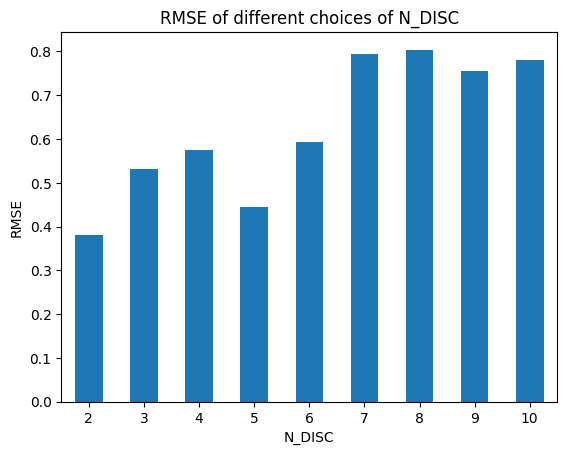

In [7]:
df.plot.bar(rot=0, title="RMSE of different choices of N_DISC", xlabel="N_DISC", ylabel="RMSE", legend=False)

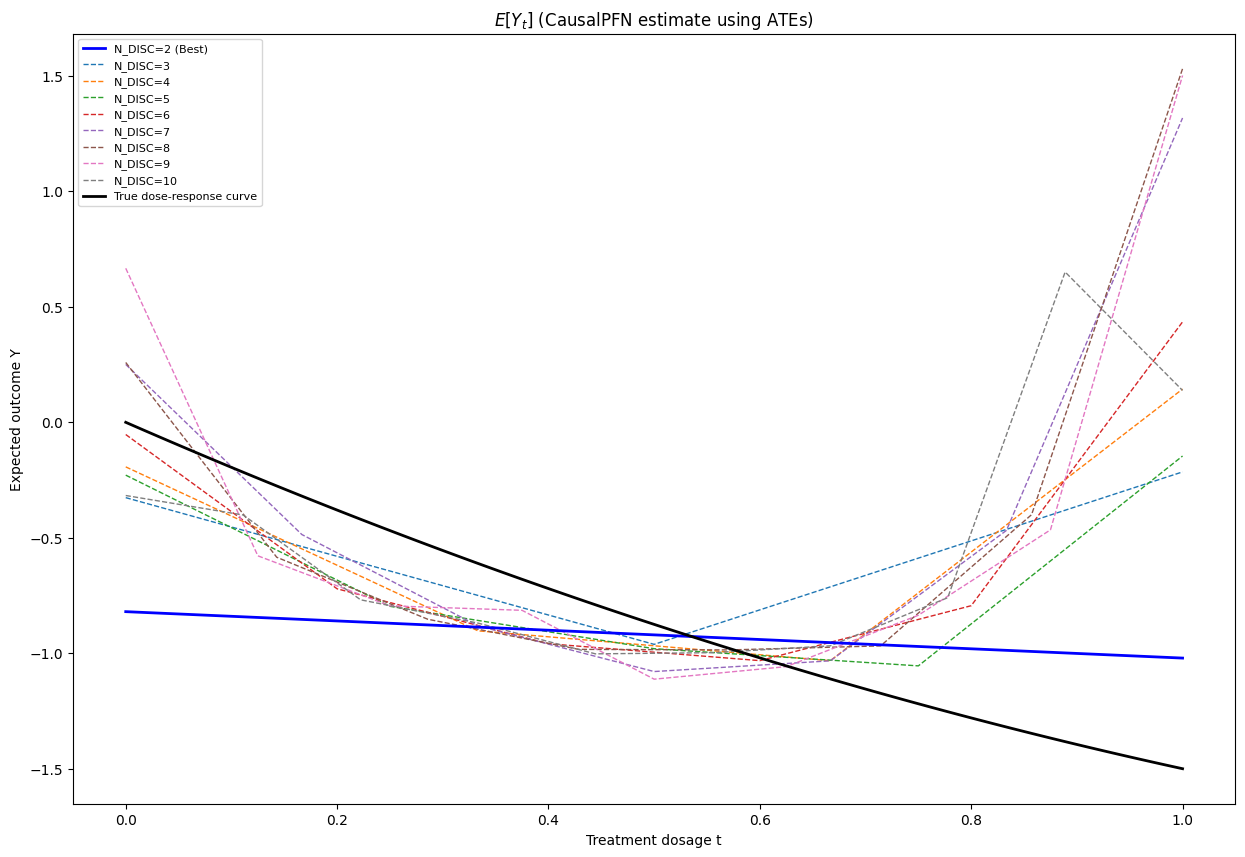

In [8]:
fig = plt.figure(figsize=(15, 10))

# Plot predictions

for N_DISC, epos in list_of_epos:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    if df.loc[N_DISC, "RMSE"] == df.min().values: # Emphasize best prediction
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '-', linewidth=2,
                 label=f"N_DISC={N_DISC} (Best)", c="blue", zorder=14)
    else:
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '--', linewidth=1,
                 label=f"N_DISC={N_DISC}")

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ (CausalPFN estimate using ATEs)") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")

plt.legend(fontsize=8)
plt.show()